In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score


# Loading data

In [2]:
path_to_data = "../../../dataset_offline/ft2model/"

targets_df = pd.read_parquet(path_to_data + "target_pandas.parquet")
dataset = pd.read_parquet(path_to_data + "filtered_features.parquet")

dataset = dataset.drop_duplicates(subset='ID_CLIENTE_BIC', keep='first')

targets_df = targets_df.sort_values(by='ID_CLIENTE_BIC', ascending=True)
dataset = dataset.sort_values(by='ID_CLIENTE_BIC', ascending=True)

# Preprocessing
Niente

# Dataset Preparation

In [3]:
# Definisci le feature (X) e il target (y)
X = dataset
y = targets_df['TARGET']

# Esegui lo split dei dati
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Tuning dei parametri

In [4]:
model = CatBoostClassifier()
params = {'iterations': [500],
          'depth': [4, 5, 6],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
          'logging_level':['Silent'],
          'random_seed': [42]
         }

scorer = make_scorer(accuracy_score)
best_model = GridSearchCV(estimator=model, param_grid=params, scoring=scorer, cv=5)
best_model.fit(X_train, y_train)
best_param = best_model.best_params_
best_param

# Training

In [38]:
best_param = best_model.best_params_
model = CatBoostClassifier(**best_param)
model.fit(X_train, y_train)

# Tuning della treshold

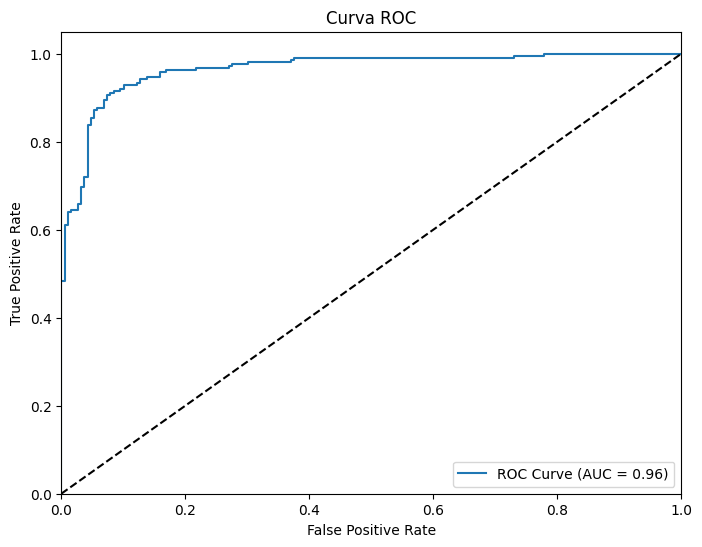

Miglior Threshold: 0.36
F1 Score Ottimizzato: 0.92


In [48]:
# Calcola le probabilità di classe previste dal modello
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilità della classe positiva

# Calcola la curva ROC e l'area sotto la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plotta la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Calcola il valore F1-score ottimizzato
f1_scores = []
for threshold in thresholds:
    y_pred_threshold = [1 if prob >= threshold else 0 for prob in y_pred_prob]
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f'Miglior Threshold: {best_threshold:.2f}')
print(f'F1 Score Ottimizzato: {best_f1_score:.2f}')

# Validation

In [52]:
# Previsioni sul set di test
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilità della classe positiva
y_pred_threshold = [1 if prob >= best_threshold else 0 for prob in y_pred_prob]


# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
roc_auc_score_value = roc_auc_score(y_test, y_pred_threshold)

# Stampa le metriche
print(f'Accuratezza: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Roc auc score: {roc_auc_score_value}')

# Aggiungere il confronto con un dummymodel

Accuratezza: 0.915
Precision: 0.9116279069767442
Recall: 0.9289099526066351
F1 Score: 0.9201877934272301
Roc auc score: 0.9141904260387673


# Cross Validation 

In [53]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')
print(f'Cross-Validation Precision Scores: {cv_scores}')
print(f'Average Precision: {np.mean(cv_scores)}')

Cross-Validation Precision Scores: [0.925      0.91612903 0.93589744 0.94       0.91082803]
Average Precision: 0.9255708987266414


# Confusion Matrix

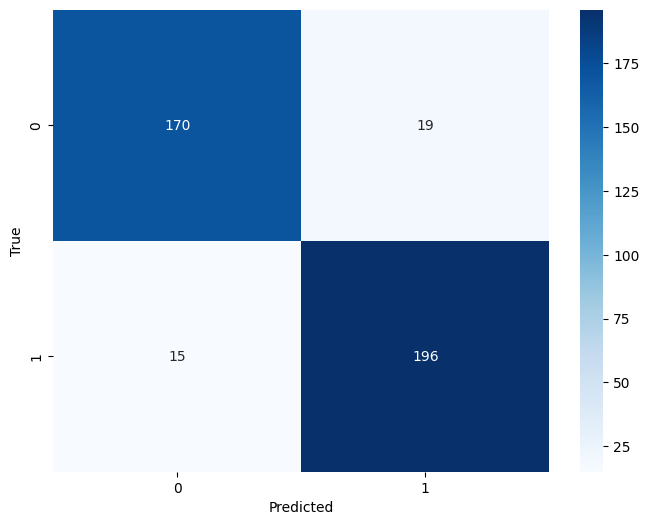

In [54]:
conf_matrix = confusion_matrix(y_test, y_pred_threshold)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Features importance

In [41]:
feature_importance = model.get_feature_importance(type= 'FeatureImportance')
feature_names = X_train.columns.tolist()

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df


,Feature,Importance
1,somma_entrate_entrate_regolari__number_peaks__n_3,11.67
28,somma_entrate_entrate_regolari__last_location_...,9.03
6,somma_entrate_entrate_regolari__number_peaks__n_1,5.38
46,"somma_uscite_tasse__linear_trend__attr_""rvalue""",5.13
9,somma_entrate_entrate_regolari__variance,3.88
...,...,...
67,somma_entrate_investimenti_patrimonio__number_...,0.02
75,somma_entrate_investimenti_patrimonio__c3__lag_1,0.02
69,somma_entrate_entrate_occasionali__median,0.02
64,somma_entrate_investimenti_patrimonio__number_...,0.01
